In [22]:
torch.cuda.is_available()

True

In [1]:
import torch
from PIL import Image
from torch.autograd import Variable
import matplotlib.pyplot as plt
import cv2
import PIL
import sys
sys.path.append("../")
import torchvision.transforms as transforms
from utils.dataset import FreiHAND
from utils.model import ShallowUNet
from utils.trainer import Trainer
from utils.prep_utils import (
    blur_heatmaps,
    IoULoss,
    COLORMAP,
    MODEL_IMG_SIZE,
    N_KEYPOINTS,
    DATASET_MEANS,
    DATASET_STDS,
    N_IMG_CHANNELS,
    get_norm_params,
    show_data,
    projectPoints,
    heatmaps_to_coordinates
)

In [2]:
loader = transforms.Compose([ transforms.Resize(MODEL_IMG_SIZE),
                            transforms.ToTensor(),
                            transforms.Normalize(DATASET_MEANS, DATASET_STDS)])
def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)
    image=image
    return image.cuda()  #assumes that you're using GPU

image1 = image_loader("ab.jpg")

In [3]:
image1 #to see how the tensor looks like

tensor([[[[-1.9892, -1.9892, -2.0092,  ...,  1.2621,  1.3419,  1.2821],
          [-1.9892, -1.9892, -2.0092,  ...,  1.2222,  1.2821,  1.2821],
          [-1.9892, -2.0092, -2.0092,  ...,  1.2621,  1.2422,  1.2222],
          ...,
          [-2.0092, -2.0092, -2.0092,  ..., -0.5530, -0.6129, -0.7326],
          [-2.0092, -2.0092, -2.0092,  ..., -1.0716, -0.9719, -0.9121],
          [-1.9693, -1.9892, -1.9693,  ..., -0.5530, -0.4533, -0.4134]],

         [[-2.4931, -2.4931, -2.4931,  ...,  1.5551,  1.5551,  1.4421],
          [-2.4931, -2.4931, -2.4931,  ...,  1.5099,  1.5325,  1.5325],
          [-2.4931, -2.4931, -2.4931,  ...,  1.5778,  1.5778,  1.5099],
          ...,
          [-2.4478, -2.4705, -2.4705,  ..., -1.0683, -1.1361, -1.2944],
          [-2.4705, -2.4931, -2.4931,  ..., -1.4980, -1.3849, -1.3397],
          [-2.4931, -2.4931, -2.4931,  ..., -0.9552, -0.8195, -0.7969]],

         [[-1.5662, -1.6089, -1.6089,  ...,  2.5989,  2.5348,  2.3853],
          [-1.6089, -1.6089, -

In [4]:
device = torch.device("cpu")
model = ShallowUNet(N_IMG_CHANNELS, N_KEYPOINTS)
#model = model.to(config["device"])
print("=> Loading Network")
model.load_state_dict(torch.load("model_final")) #, map_location=torch.device("cuda")
model = model.to(device)
model.eval()

=> Loading Network


ShallowUNet(
  (conv_down1): ConvBlock(
    (double_conv): Sequential(
      (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (2): ReLU(inplace=True)
      (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (5): ReLU(inplace=True)
    )
  )
  (conv_down2): ConvBlock(
    (double_conv): Sequential(
      (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (2): ReLU(inplace=True)
      (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (5): ReLU(inplace=True)
    )
  )
  (conv_down3

In [5]:
with torch.no_grad():
    roi_torch=Variable(image1)
    roi_torch=roi_torch.type(torch.FloatTensor)
    keypoints=model(roi_torch)
pred_heatmaps=keypoints.detach().numpy()
pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)[0]*212
a=pred_keypoints
print(a)

[[ 85.52726  102.18169 ]
 [ 83.73699  116.95217 ]
 [ 81.76916  106.56465 ]
 [ 80.8894    97.02645 ]
 [ 89.44891   88.48224 ]
 [104.778885  96.5519  ]
 [114.19444   85.43927 ]
 [126.87791   81.20154 ]
 [136.40443   78.20325 ]
 [113.75237   98.78316 ]
 [126.02762   89.41107 ]
 [137.31395   86.334625]
 [147.4317    84.68363 ]
 [118.83222  109.32935 ]
 [131.74802  101.25707 ]
 [143.32549   97.39403 ]
 [149.8779    94.023964]
 [119.040115 119.57782 ]
 [130.82231  115.914795]
 [138.53201  115.554344]
 [143.44917  111.39363 ]]


(-0.5, 223.5, 223.5, -0.5)

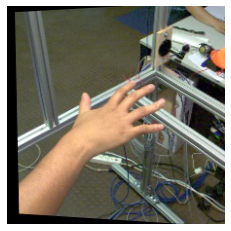

In [6]:
origimage=cv2.imread("ab.jpg")[:,:,::-1]
plt.imshow(origimage)
plt.axis("off")

(-0.5, 223.5, 223.5, -0.5)

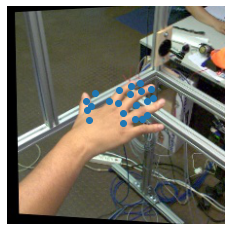

In [7]:
#plt.imshow(cv2.imread("ab5.jpg")[:,:,::-1])
plt.imshow(origimage)
plt.scatter([a[i][0] for i in range(21)],[a[i][1] for i in range(21)])
plt.axis("off")

(-0.5, 223.5, 223.5, -0.5)

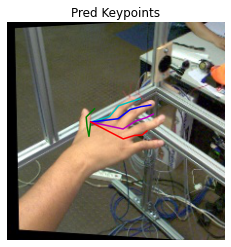

In [8]:
plt.imshow(origimage)
for finger, params in COLORMAP.items():
    plt.plot(
        pred_keypoints[params["ids"], 0],
        pred_keypoints[params["ids"], 1],
        params["color"],
    )
plt.title("Pred Keypoints")
plt.axis("off")